# Tutorial for finding the ground state for the Schrödinger equation in 1D using imaginary time propagation (`expsolve.splittings` and `expsolve.fourier`)

This notebook introduces you to the basic idea of imaginary time propagation with the example of the Schrödinger equation in 1D. 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [2]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt
import expsolve as es

# Power iterations

Consider a matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ with normalised eigenvectors $v_1,\ldots,v_n \in \mathbb{C}^n$ corresponding to eigenvalues $\lambda_1,\ldots,\lambda_n \in \mathbb{C}$. Let 

$$u^{[0]} = \sum_{j=1}^n c_j v_j, \qquad c_1,\ldots,c_n \neq 0$$

be an initial vector such that $\|u^{[0]}\|=1$, which has components along all eigenvectors. Then the power iteration is

$$ v = \mathbf{A} u^{[k]}, \qquad u^{[k+1]} := v/\|v\|, \qquad k = 0, 1, \ldots $$

Let $\lambda_*$ be the largest eigenvalue by magnitude and $v_*$ be the eigenvector corresponding to this eigenvalue. Since $\mathbf{A}^k u^{[0]} = \sum_{j=1}^n c_j \lambda_j^k v_j$, eventually the $v_*$ component dominates and 
$$\mathbf{A}^k u^{[0]} \sim c_* \lambda_*^k v_*.$$ 

Due to the normalisation step, $v/\|v\|$, 

$$u^{[k]} \rightarrow v^*.$$

## Imaginary time power iteration

In quantum mechanics, we can assume that the eigenvalues $\lambda_1,\ldots,\lambda_n \in \mathbb{R}$ of the Hermitian Hamiltonian matrix $\mathbf{H}$ are ordered $\lambda_k \leq \lambda_{k+1}$, and typically we are interested in the ground state $v_0$ corresponding to the the most negative eigenvalue $\lambda_0$. The power iteration method (or even the inverse power iteration) cannot work for this task. Instead, we need an approach that will increase the contribution of $v_0$ and decrease that of others. This can be achieved by doing power iterations with 

$$\mathbf{A} = \exp(-\mathbf{H}).$$

Power iteration with $\exp(-\mathbf{H})$ makes components corresponding to positive eigenvalues decay rapidly,

$$\mathbf{A}^k u^{[0]} = \exp(-k\mathbf{H}) u^{[0]} = \sum_{j=1}^n c_j \exp(-k\lambda_j) v_j \sim c_0 \exp(-k \lambda_0) v_0.$$ 

Since all other components decay faster than $v_0$, after normalisation we are eventually left with the $v_0$ component, i.e. the ground state:

$$u^{[k]} \rightarrow v_0.$$

The method is called imaginary time propagation since the usual time propagation in time-dependent Schrödinger equation requires the computation of $\exp(-i t \mathbf{H})$. Replacing $t = -i k$, i.e. using an imaginary time, we get $\exp(-k \mathbf{H}) = \mathbf{A}^k$, which corresponds to the above iteration. 

### Splittings

There is another crucial aspect in which the imaginary time power iteration differs from the usual power iterations: The computation of $\mathbf{A} = \exp(-\mathbf{H})$, and its application $v=\mathbf{A} u^{[k]}$ in each step of the power iteration, is far from trivial. Instead, we can rely on a splitting for approximating this exponential. For a detailed tutorial on splittings, refer to the `tutorialclassical` Notebook. 

Let us say that $\mathbf{H}=\mathbf{X}+\mathbf{Y}$, where it is easier or cheaper to compute the actions $\exp(-\mathbf{X}) w$ and $\exp(-\mathbf{Y})w$ than to compute $\exp(-\mathbf{H}) w$. Then we can use a splitting approximation for the matrix exponential,

$$ \exp(-h \mathbf{H}) = \exp(-h (\mathbf{X}+\mathbf{Y})) = \exp\left(-\frac{h}{2} \mathbf{Y} \right)  \exp(-h \mathbf{X}) \exp\left(-\frac{h}{2} \mathbf{Y} \right) + \mathcal{O}(h^3)$$

where $h$ is a small time-step. Eventually, since we are interested in the behaviour under $k \rightarrow \infty$, it does not matter that we work with $\mathbf{A} = \exp(-h \mathbf{H})$ instead of $\mathbf{A} = \exp(-\mathbf{H})$. A small time step allows us to make more accurate approximations to the exponential, albeit at an expense of the number of power iterations needed. 







# Ground state of the Schrödinger equation

The time-independent Schrödinger equation (TISE) in 1D with periodic boundaries over a domain $[-L,L]$ can be written as

$$ \mathrm{H} \psi(x,t) = \mathrm{E} \psi(x,t), \qquad x \in [-L,L] $$

where $\mathrm{H}$ is the Hamiltonian operator,

$$ \mathrm{H} = -\partial_x^2 + V(x) $$

and $V(x)$ is a real-valued potential function. Typically, we spatially discretise the PDE eigenvalue problem, replacing the Hamiltonian operator $\mathrm{H}$ with a discretised Hamiltonian matrix $\mathbf{H}$, and arriving at the matrix eigenvalue problem:

$$ \mathbf{H} u(t) =  \mathrm{E} u(t), $$

where $u(t)$ is now a vector of values on the spatial grid, and the discretised Hamiltonian matrix is

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

## The splitting approach for power iteration

The splitting approach is to approximate the matrix exponential $\exp(-h \mathbf{H})$ which has a cost of $\mathcal{O}(n^3)$ by a splitting:

$$ v = \exp\left(- \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(h\, \mathbf{D}_2\right) \ \exp\left(- \frac{h}{2}\, \texttt{diag}(V) \right) u^{[k]} $$

This splitting is useful when the differentiation matrix $\mathbf{D}_2$ can be diagonalised with the Fourier transform, for instance,

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). 

In `expsolve.fourier`, the function `diffop` computes the action of $\mathbf{D}_k$ on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preferred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

With the help of Taylor expanion, we can also seee that exponential of $\mathbf{D}_k$ is

$$ \exp(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ \exp(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} u = \texttt{ifft}\left( \exp(c s_k) \texttt{fft}(u) \right) .$$

This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDu = expsolve.fourier.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c D_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $D_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* Since we are working in 1D here, $j=0$. 
* Since we need 2nd derivative, $k=2$. 

### Grid & Initial Condition

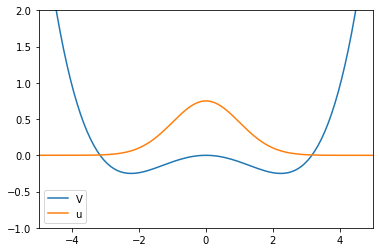

In [34]:
n = 200
L = 10
xr = [-L, L]
x = es.fourier.grid1d(n, xr)

x0 = 0.0
u = np.exp(-(x-x0)**2/2)

u = u/es.fourier.l2norm(u, xr)

V = x**4 - 10*x**2

plt.plot(x, V/100)
plt.plot(x, u)
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### Strang splitting

We create lambda functions for computing $\exp(h D_2) u$ and $\exp(-h \texttt{diag}(V)) u$, and compose them to form a single step of Strang:

$$\exp\left(- \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(h\, \mathbf{D}_2\right) \ \exp\left(- \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

In [35]:
eLu = lambda t, tauV, h, c, u: es.fourier.diffopexp(0, 2, c*h, u, xr)
eVu = lambda t, tauL, h, c, u: np.exp(-c*h*V)*u

strangalpha, strangbeta = es.splittings.classical.symmetric([],[])
print(strangalpha, strangbeta)

imaginarystep = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

[0.5, 0.5] [1.0, 0]


Ignore `tauL` and `tauV`. These are useful only for time-dependent Schrödinger equations with time-dependent Hamiltonians. 

Once the stepper is ready, we can use `expsolve.evolve` to simulate over a large period $[0,T]$, following which we normalise the solution. 

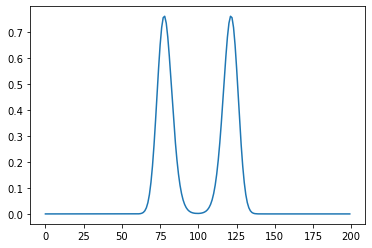

In [36]:
T = 10
N  = 1000

uT = es.evolve(u, es.timegrid(T, N), imaginarystep)[0]

uT = uT/es.fourier.l2norm(uT,xr)

plt.plot(np.abs(uT))
plt.show()

How far is this from being an eigenvector?

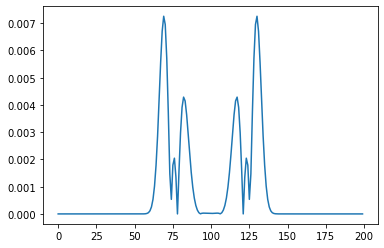

In [43]:
w = uT
c = np.max(np.abs(H.dot(w)))/np.max(np.abs(w))
plt.plot(np.abs(H.dot(w)+c*w))
plt.show()

The error is roughly `7e-3`. Let's check the error or our splitting approach compared to the brute force solution obtained by `expm`

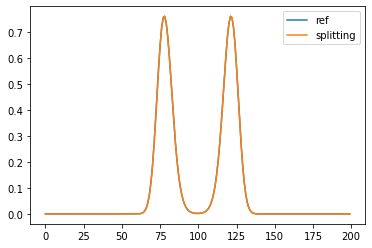

The L2 error in splitting is 0.0003734075295416061


In [44]:
D2 = es.fourier.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)
urefT = expm(-T*H).dot(u)
urefT = urefT/es.fourier.l2norm(urefT,xr)

plt.plot(np.abs(urefT))
plt.plot(np.abs(uT))
plt.legend(['ref','splitting'])
plt.show()

print(f'The L2 error in splitting is {es.fourier.l2norm(urefT-uT, xr)}')

They look the same, but error in splitting is `4e-4` roughly. And what about the brute force reference solution? How far is it from being an eigenvector?

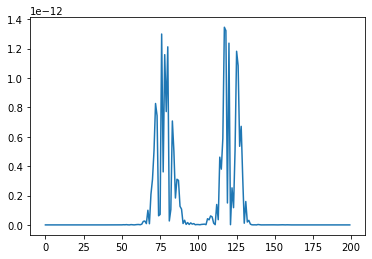

In [42]:
w = urefT
c = np.max(np.abs(H.dot(w)))/np.max(np.abs(w))
plt.plot(np.abs(H.dot(w)+c*w))
plt.show()

We can see that the reference solution is eigenvector to `1e-12` accuracy. So if we can compute matrix exponential to higher accuracy, maybe we can find a more accurate solution? 

### Longer simulation

What about longer time simulation (larger $T$) with the same number of time steps? This would make time steps larger and approximation of matrix exponential less accurate. 

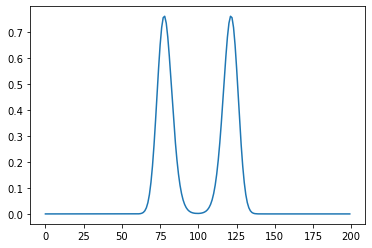

In [54]:
T = 10
N  = 1000

for i in range(10):
    # doing in a loop since currently es.evolve cannot force normalisation, and we don't want blowup
    uT = es.evolve(u, es.timegrid(T, N), imaginarystep)[0]
    uT = uT/es.fourier.l2norm(uT,xr)

plt.plot(np.abs(uT))
plt.show()

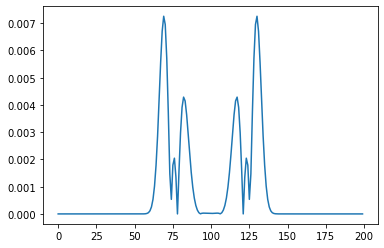

In [55]:
w = uT
c = np.max(np.abs(H.dot(w)))/np.max(np.abs(w))
plt.plot(np.abs(H.dot(w)+c*w))
plt.show()

Not much of an improvement! That makes sense. The true solution with `expm` has already achieved `1e-12` accuracy, and our problem is in better approximation of the matrix exponential via splittings. 

### Shorter time, shorter time steps

First let's investigate the `expm` solution:

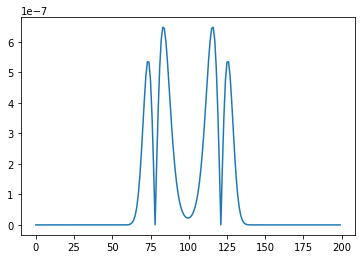

In [60]:
T = 2

D2 = es.fourier.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)
urefT = expm(-T*H).dot(u)
urefT = urefT/es.fourier.l2norm(urefT,xr)

w = urefT
c = np.max(np.abs(H.dot(w)))/np.max(np.abs(w))
plt.plot(np.abs(H.dot(w)+c*w))
plt.show()

Now that we have managed a reasonable accuracy with the brute force, we can target achieving similar accuracy with the splitting:

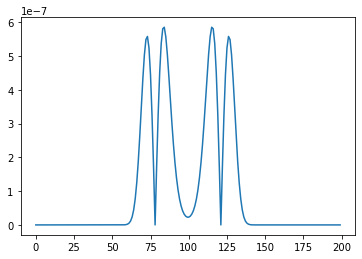

In [68]:
T = 2
N  = 5e4

uT = es.evolve(u, es.timegrid(T, N), imaginarystep)[0]

uT = uT/es.fourier.l2norm(uT,xr)

w = uT
c = np.max(np.abs(H.dot(w)))/np.max(np.abs(w))
plt.plot(np.abs(H.dot(w)+c*w))
plt.show()


Of course, in practice we do not have the brute force solution, which costs $\mathcal{O}(n^3)$, and we need to figure out $T$ and $N$ using estimates and heuristics.